***
# Evaluation of Different RPLH Systems
***

In [57]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
import pandas as pd
import matplotlib.pyplot as plt

current_folder = Path.cwd()
parent_folder = current_folder.parent.parent
sys.path.insert(0, str(parent_folder))
print(parent_folder)

from rplh.evaluation.get_data import get_data
from rplh.evaluation.embed import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/kevinb/Desktop/dsc190/RPLH


# Importing Data With Our Getter Functions

In [58]:
print("LOADING RPLH-SPY-AGENT...")
base_dir = parent_folder / "gpt-agent-testing-env-1"
df_a_spy, success_df_a_spy, spy_count_df, spy_df, att_df, justification_df = get_data(base_dir, 20)

print("\nLOADING RPLH-SPY-STANDARD...")
base_dir = parent_folder / "gpt-standard-testing-env-1"
df_s_spy, success_df_s_spy, _, _, _, _ = get_data(base_dir, 20)

print("\nLOADING RPLH-NoSPY-STANDADRD...")
base_dir = parent_folder / "gpt-standard-testing-nospy-env-1"
df_s_nospy, success_df_s_nospy, _, _, _, _ = get_data(base_dir, 10)

LOADING RPLH-SPY-AGENT...
trial_6: Not Converged
trial_7: Not Converged
trial_15: Not Converged
trial_17: Not Converged
trial_19: Not Converged
trial_20: Not Converged

LOADING RPLH-SPY-STANDARD...
trial_5: Not Converged
trial_9: Not Converged
trial_10: Not Converged
trial_17: Not Converged
trial_19: Not Converged
trial_20: Not Converged

LOADING RPLH-NoSPY-STANDADRD...
trial_3: Not Converged
trial_7: Not Converged
trial_8: Not Converged
trial_9: Not Converged


In [59]:
agent_spy_merged = df_a_spy.merge(success_df_a_spy, on="Trial")
standard_spy_merged = df_s_spy.merge(success_df_s_spy, on="Trial")
standard_nospy_merged = df_s_nospy.merge(success_df_s_nospy, on="Trial")

In [60]:
agent_round = spy_count_df.divide(spy_count_df.sum(axis=1), axis=0).round(2)
agent_round.idxmax(axis=1).value_counts()

Agent[1.5, 1.5]    9
Agent[0.5, 1.5]    8
Agent[1.5, 0.5]    2
Agent[2.5, 1.5]    1
Name: count, dtype: int64

***
# Aggregated Senetnce Embedding Analysis
***

Easiest idea, let's `explode()` all the sentence respond in agent models to see similarity with given spy or non-spy sentence.

Test to see if embedding function working.

In [61]:
sentence1 = "The cat sat on the mat."
sentence2 = "A cat was sitting on the mat."

embedding_1 = get_embedding(sentence1)
embedding_2 = get_embedding(sentence2)

cosine_sim(embedding_1, embedding_2)

0.9777018864480065

Need to check last few ones

### Compare aggregated nice senntence with nice agent spy agent in `att_df`

In [62]:
sentence1 = "Seems to be be very easy going, trying to find agreement with the central ageent and the goal is to resolve conversation."
sentence2 = "".join(str(att_df['Agent[2.5, 1.5]'].explode().unique()))
sentence3 = "".join(str(att_df['Agent[2.5, 0.5]'].explode().unique()))
sentence4 = "".join(str(att_df['Agent[1.5, 1.5]'].explode().unique()))

print(f"Compare represenattion between nice sentence and nice agent: {cosine_sim(get_embedding(sentence1), get_embedding(sentence3))}")
print(f"Compare representation between nice sentence and spy agent: {cosine_sim(get_embedding(sentence1), get_embedding(sentence4))}")
print(f"Compare represenattion of 2 nice agent: {cosine_sim(get_embedding(sentence2), get_embedding(sentence3))}")

Compare represenattion between nice sentence and nice agent: 0.477384468842258
Compare representation between nice sentence and spy agent: 0.41071185602423244
Compare represenattion of 2 nice agent: 0.9030917904335105


### Compare aggregated spy sentence with non-spy agent and spy agent in `att_df`

In [63]:
sentence1 = "Seems to be the spy agent, its goal is to prevent match targets."
sentence2 = "".join(str(att_df['Agent[1.5, 1.5]'].explode().unique()))
sentence3 = "".join(str(att_df['Agent[2.5, 0.5]'].explode().unique()))

print(f"Compare represenattion between spy sentence and spy agent: {cosine_sim(get_embedding(sentence1), get_embedding(sentence2))}")
print(f"Compare represenattion between spy sentence and non-spy agent: {cosine_sim(get_embedding(sentence1), get_embedding(sentence3))}")

Compare represenattion between spy sentence and spy agent: 0.6157219010540025
Compare represenattion between spy sentence and non-spy agent: 0.6053309840915431


Aggregated sentence embedding doesn't seem to work so well.

***
# Per-Trial Senetnce Embedding Analysis
***

Let's now use the look at similarity per trial instead of an aggregated sentence we will look at
- `agent model` embedding similarity with spy sentence.
- `spy model` embedding similarity with spy sentence.
- `agent model` embedding similarity with non-spy sentence.
- `justificatoon` embedding with justification sentence to see if suspecting is given.

In [64]:
df_trial_embed = pd.DataFrame()
sentence1 = "Seems to be the spy agent, its goal is to prevent match targets"
sentence2 = "Seems to be be very easy going, trying to find agreement with the central ageent and the goal is to resolve conversation."
sentence3 = "I suspect that this agent is the spy agent, thus, I would not listen to this agent."
embedding_1 = get_embedding(sentence1)
embedding_2 = get_embedding(sentence2)
embedding_3 = get_embedding(sentence3)

df_trial_embed['Att_Embed_SpySent_Agent[1.5, 1.5]'] = att_df.reset_index()['Agent[1.5, 1.5]'].apply(lambda x: cosine_sim(embedding_1, get_embedding(str(x))))
df_trial_embed['Att_Embed_NonSpySent_Agent[1.5, 1.5]'] = att_df.reset_index()['Agent[1.5, 1.5]'].apply(lambda x: cosine_sim(embedding_2, get_embedding(str(x))))
df_trial_embed['Spy_Embed_SpySent_Agent[1.5, 1.5]'] = spy_df.reset_index()['Agent[1.5, 1.5]'].apply(lambda x: cosine_sim(embedding_1, get_embedding(str(x))))
df_trial_embed['Justification_Embed'] = justification_df.reset_index()['Justifications'].apply(lambda x: cosine_sim(embedding_3, get_embedding(str(x))))
df_trial_embed

,"Att_Embed_SpySent_Agent[1.5, 1.5]","Att_Embed_NonSpySent_Agent[1.5, 1.5]","Spy_Embed_SpySent_Agent[1.5, 1.5]",Justification_Embed
0,0.498783,0.431337,0.583837,0.617001
1,0.555409,0.369837,0.634192,0.500486
2,0.579711,0.396482,0.680379,0.650587
3,0.620892,0.446607,0.747992,0.651606
4,0.555391,0.406046,0.599418,0.602094
5,0.560213,0.492380,0.579917,0.598154
6,0.589882,0.488796,0.636751,0.640405
7,0.517687,0.408757,0.561800,0.557793
8,0.487824,0.472294,0.524487,0.624391
9,0.551335,0.437907,0.526782,0.572241


***
# Structured Embedding Similarity Analysis
***

We have written a function to do similar things as the above, but more rigrously and get everything directly.

In [65]:
spy_embedding = get_spy_detect_embedding(agent_spy_merged, spy_df, justification_df,
                                         spy_sentence="Seems to be the spy agent, its goal is to prevent match targets.",
                                         just_sentence="I suspect that this agent is the spy agent, thus, I would not listen to this agent.",
                                         spy_agents=["Agent[0.5, 0.5]", "Agent[1.5, 1.5]", "Agent[2.5, 2.5]"],
                                         only_spy=True)
spy_embedding

,Trial,Num_Boxes,Avg_Boxes_To_Targets_Per_Response,Avg_Boxes_To_Other_Per_Response,Convergence,"Spy_Embed_Agent[0.5, 0.5]","Spy_Embed_Agent[2.5, 2.5]","Spy_Embed_Agent[1.5, 1.5]",Justification_Embed
0,trial_1,8,1.000000,1.250000,Converged,0.675143,0.353954,0.594204,0.617001
1,trial_2,11,0.550000,1.850000,Converged,0.647305,0.734128,0.640134,0.500486
2,trial_3,11,0.440000,1.880000,Converged,0.618273,0.621723,0.684246,0.650587
3,trial_4,10,0.769231,2.076923,Converged,0.657759,0.733541,0.753357,0.651606
4,trial_5,12,0.375000,2.593750,Converged,0.528011,0.536061,0.604009,0.602094
5,trial_6,12,1.250000,2.500000,Not Converged,0.565911,0.577602,0.587502,0.598154
6,trial_7,10,0.272727,2.303030,Not Converged,0.457362,0.598549,0.647122,0.640405
7,trial_8,8,0.470588,2.294118,Converged,0.634957,0.716670,0.565344,0.557793
8,trial_9,10,0.526316,2.263158,Converged,0.556357,0.625864,0.529466,0.624391
9,trial_10,11,0.846154,1.923077,Converged,0.546744,0.544890,0.529662,0.572241


In [66]:
filtered_spy_embed = spy_embedding[spy_embedding['Convergence']=="Converged"]
filtered_spy_embed.describe()

,Num_Boxes,Avg_Boxes_To_Targets_Per_Response,Avg_Boxes_To_Other_Per_Response,"Spy_Embed_Agent[0.5, 0.5]","Spy_Embed_Agent[2.5, 2.5]","Spy_Embed_Agent[1.5, 1.5]",Justification_Embed
count,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000
mean,9.785714,0.548634,2.027543,0.570538,0.643230,0.619103,0.615159
std,1.577660,0.206993,0.338697,0.108039,0.109523,0.074772,0.050114
min,8.000000,0.218750,1.250000,0.353954,0.353954,0.529466,0.500486
25%,8.000000,0.441111,1.890000,0.532694,0.599519,0.567079,0.590435
50%,10.000000,0.513158,1.953125,0.587794,0.683120,0.599107,0.619610
75%,11.000000,0.622794,2.241486,0.644218,0.725615,0.673218,0.651351
max,12.000000,1.000000,2.593750,0.711985,0.734128,0.753357,0.698648


In [67]:
from tabulate import tabulate
markdown_table = tabulate(filtered_spy_embed.describe(), headers='keys', tablefmt='pipe')
print(markdown_table)

|       |   Num_Boxes |   Avg_Boxes_To_Targets_Per_Response |   Avg_Boxes_To_Other_Per_Response |   Spy_Embed_Agent[0.5, 0.5] |   Spy_Embed_Agent[2.5, 2.5] |   Spy_Embed_Agent[1.5, 1.5] |   Justification_Embed |
|:------|------------:|------------------------------------:|----------------------------------:|----------------------------:|----------------------------:|----------------------------:|----------------------:|
| count |    14       |                           14        |                         14        |                   14        |                   14        |                  14         |            14         |
| mean  |     9.78571 |                            0.548634 |                          2.02754  |                    0.570538 |                    0.64323  |                   0.619103  |             0.615159  |
| std   |     1.57766 |                            0.206993 |                          0.338697 |                    0.108039 |                    0.109

Let's use all the features, not just the spy ones

In [68]:
spy_embedding = get_spy_detect_embedding(agent_spy_merged, spy_df, justification_df,
                                         spy_sentence="Seems to be the spy agent, its goal is to prevent match targets.",
                                         just_sentence="I suspect that this agent is the spy agent, thus, I would not listen to this agent.",
                                         spy_agents=["Agent[0.5, 0.5]", "Agent[1.5, 1.5]", "Agent[2.5, 2.5]"],
                                         only_spy=False)

***
# Create Big DF for Correlation Studies
***

In [69]:
standard_for_merge_spy = standard_spy_merged.drop(columns=["Num_Responses", "Boxes_To_Targets", "Boxes_To_Other"])
standard_for_merge_nospy = standard_nospy_merged.drop(columns=["Num_Responses", "Boxes_To_Targets", "Boxes_To_Other"])

spy_embedding["Have_spy"] = 1
standard_for_merge_spy["Have_spy"] = 1
standard_for_merge_nospy["Have_spy"] = 0

In [79]:
rplh_df = pd.concat([spy_embedding, standard_for_merge_spy, standard_for_merge_nospy], axis=0, ignore_index=True).drop(columns=["Trial", "Convergence", "Avg_Boxes_To_Other_Per_Response"]).fillna(0)

Avg_Boxes_To_Targets_Per_Response    1.000000
Spy_Embed_Agent[1.5, 1.5]            0.419380
Justification_Embed                  0.407601
Spy_Embed_Agent[0.5, 0.5]            0.361688
Spy_Embed_Agent[2.5, 2.5]            0.346983
Num_Boxes                            0.301697
Name: Avg_Boxes_To_Targets_Per_Response, dtype: float64


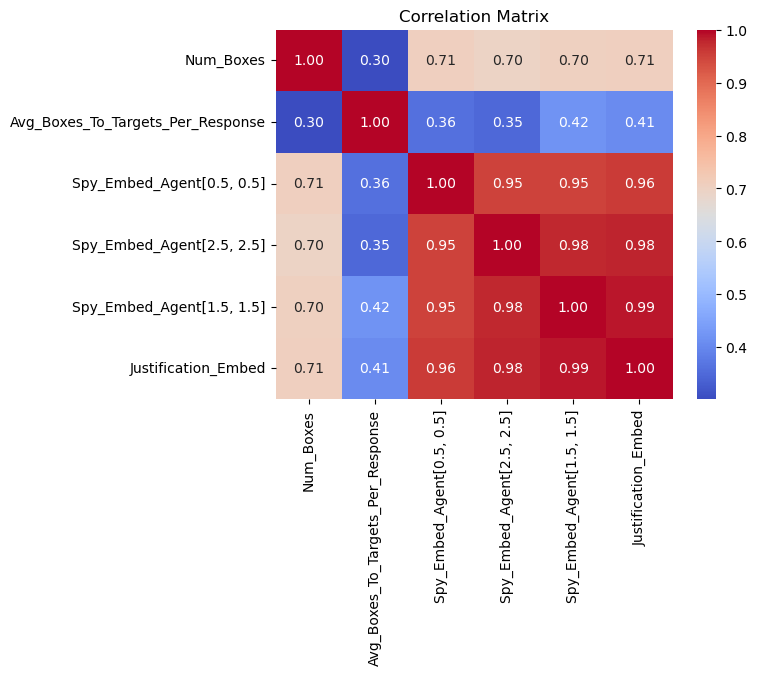

In [71]:
import seaborn as sns

spy_embedding_small = get_spy_detect_embedding(agent_spy_merged, spy_df, justification_df,
                                         spy_sentence="Seems to be the spy agent, its goal is to prevent match targets.",
                                         just_sentence="I suspect that this agent is the spy agent, thus, I would not listen to this agent.",
                                         spy_agents=["Agent[0.5, 0.5]", "Agent[1.5, 1.5]", "Agent[2.5, 2.5]"],
                                         only_spy=True)

rplh_df_small = (pd.concat([spy_embedding_small, standard_for_merge_spy, standard_for_merge_nospy], axis=0, ignore_index=True)
                 .drop(columns=["Trial", "Convergence", "Avg_Boxes_To_Other_Per_Response", "Have_spy"])
                 .fillna(0))

correlation_matrix = rplh_df_small.corr()
target_corr = correlation_matrix["Avg_Boxes_To_Targets_Per_Response"].sort_values(ascending=False)

print(target_corr)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

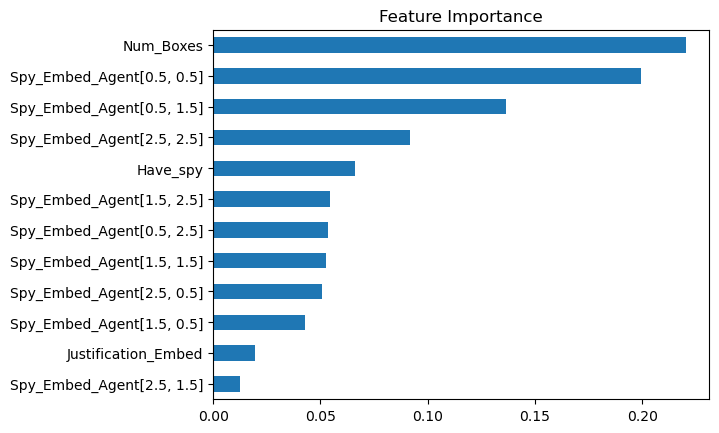

In [72]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X = rplh_df.drop(columns=["Avg_Boxes_To_Targets_Per_Response"])
y = rplh_df["Avg_Boxes_To_Targets_Per_Response"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind="barh", title="Feature Importance")
plt.show()

Explained Variance Ratio: [0.8718467  0.06854219]


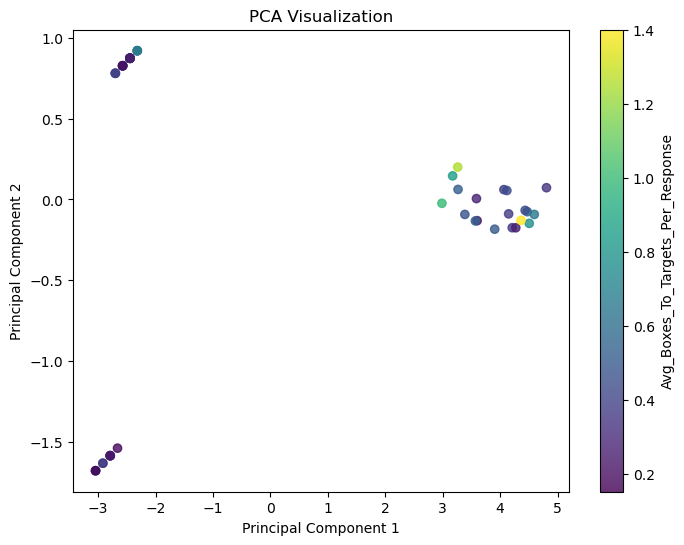

In [73]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

numeric_features = rplh_df.select_dtypes(include="number").drop(columns=["Avg_Boxes_To_Targets_Per_Response"])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_features)

pca = PCA(n_components=2)
pca_results = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(pca_results, columns=["PC1", "PC2"])
pca_df["Avg_Boxes_To_Targets_Per_Response"] = rplh_df["Avg_Boxes_To_Targets_Per_Response"]
print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    pca_df["PC1"], pca_df["PC2"],
    c=pca_df["Avg_Boxes_To_Targets_Per_Response"], cmap="viridis", alpha=0.8
)
plt.colorbar(scatter, label="Avg_Boxes_To_Targets_Per_Response")
plt.title("PCA Visualization")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

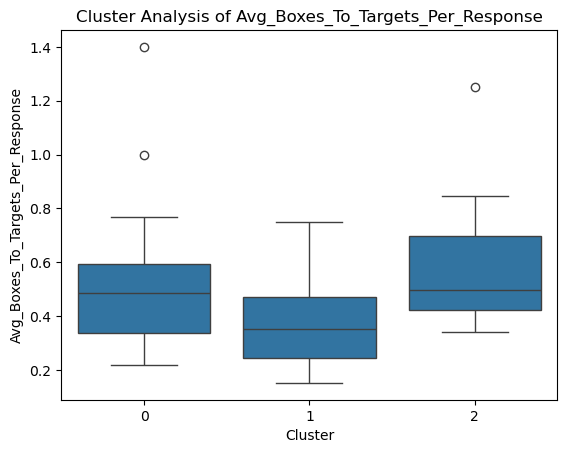

In [74]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
rplh_df['Cluster'] = kmeans.fit_predict(rplh_df.drop(columns=["Avg_Boxes_To_Targets_Per_Response"]))

sns.boxplot(x='Cluster', y='Avg_Boxes_To_Targets_Per_Response', data=rplh_df)
plt.title("Cluster Analysis of Avg_Boxes_To_Targets_Per_Response")
plt.show()

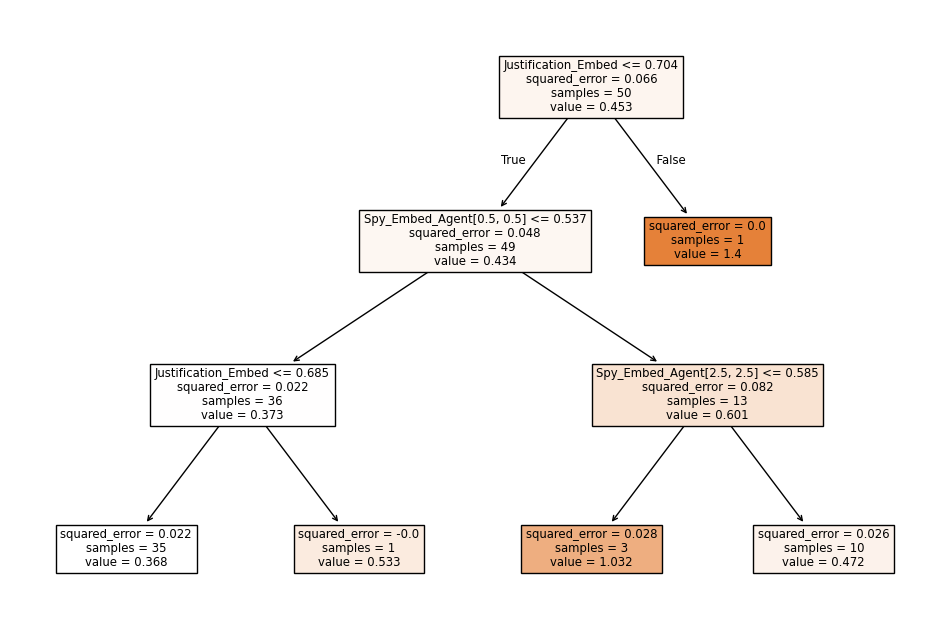

In [75]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

tree = DecisionTreeRegressor(max_depth=3, random_state=42)
tree.fit(X, y)

plt.figure(figsize=(12, 8))
plot_tree(tree, feature_names=X.columns, filled=True)
plt.show()

***
# Comparing Performance Across Systems
***

In [76]:
agent_spy_merged.compare(standard_spy_merged)

Num_Boxes       Num_Responses       Boxes_To_Targets       Boxes_To_Other  \
        self other          self other             self other           self   
0        8.0   6.0             8     9              8.0   6.0             10   
1       11.0   8.0            20    12             11.0   8.0             37   
2       11.0   9.0            25    17             11.0   9.0             47   
3       10.0   8.0            13    24             10.0   8.0             27   
4       12.0   6.0            32    14             12.0   5.0             83   
5       12.0   7.0             4    14              5.0   7.0             10   
6       10.0   8.0            33    24              9.0   8.0             76   
7        8.0   6.0            17    15              8.0   6.0             39   
8       10.0   8.0            19    27             10.0   7.0             43   
9       11.0   7.0            13    35             11.0   6.0             25   
10      11.0   7.0            17    14             11.0   7.0             37   
11      12.0   9.0            27    30             12.0   9.0             68   
12       NaN   NaN            32    31              7.0   8.0             63   
13       NaN   NaN            25    12              NaN   NaN             48   
14      10.0   7.0            24    23              9.0   7.0             49   
15       NaN   NaN            16    22              NaN   NaN             31   
16      14.0   8.0            38    46             13.0   7.0             83   
17       NaN   NaN            15    17              NaN   NaN             26   
18       9.0   8.0            27    31              NaN   NaN             55   
19      10.0   7.0             5    32              7.0   6.0             12   

         Avg_Boxes_To_Targets_Per_Response            \
   other                              self     other   
0     11                          1.000000  0.666667   
1     17                          0.550000  0.666667   
2     22                          0.440000  0.529412   
3     40                          0.769231  0.333333   
4     27                          0.375000  0.357143   
5     29                          1.250000  0.500000   
6     50                          0.272727  0.333333   
7     18                          0.470588  0.400000   
8     46                          0.526316  0.259259   
9     70                          0.846154  0.171429   
10    20                          0.647059  0.500000   
11    59                          0.444444  0.300000   
12    54                          0.218750  0.258065   
13    18                          0.360000  0.750000   
14    44                          0.375000  0.304348   
15    33                          0.500000  0.363636   
16   111                          0.342105  0.152174   
17    24                          0.533333  0.470588   
18    51                          0.259259  0.225806   
19    51                          1.400000  0.187500   

   Avg_Boxes_To_Other_Per_Response              Convergence                 
                              self     other           self          other  
0                         1.250000  1.222222            NaN            NaN  
1                         1.850000  1.416667            NaN            NaN  
2                         1.880000  1.294118            NaN            NaN  
3                         2.076923  1.666667            NaN            NaN  
4                         2.593750  1.928571      Converged  Not Converged  
5                         2.500000  2.071429  Not Converged      Converged  
6                         2.303030  2.083333  Not Converged      Converged  
7                         2.294118  1.200000            NaN            NaN  
8                         2.263158  1.703704      Converged  Not Converged  
9                         1.923077  2.000000      Converged  Not Converged  
10                        2.176471  1.428571            NaN            NaN  
11      

In [77]:
# agent_spy_merged.compare(standard_spy_merged)